# IDAWEB data
This notebook covers the whole process of gathering station data from the idaweb service from start to finish. This includes the regional selection, parameter and station selection, preprocessing, outlier correction, ... 

The processed data is stored in new files.

## Define coordinate rectangle around the Upper Grindelwald Glacier
We are looking for stations in vicinity of the Upper Grindelwald Glacier (UGG) in order to compare the HistAlp climate with the actual temperature/precipitation in that region. Therefore I define an arbitrary field around the UGG, and print the coordinates of its vertices in a certain format to use it with the IDAWEB service. Therefore I use functions of my `utils` module and my `idaweb` module.

In [2]:
# import section
import os
import numpy as np
import pandas as pd
from oggm import utils

import sys
sys.path.append('../code/')
import utils as mutils
import idaweb

In [3]:
# get RGI entry for Upper Grindelwald Glacier
rgi_id = '11.01270'
rgi_df = mutils.rgi_finder([rgi_id])

In [4]:
# get center coordinates
c_lon = rgi_df.CenLon.values[-1]
c_lat = rgi_df.CenLat.values[-1]

# specify window size in km
width = 60
height = 40

# compute window vertices
limits = idaweb.get_wgs_limits(c_lon, c_lat, width, height)
# show values
for l in limits:
    print(l)


7°44'..8°31'
46°26'..46°48'


In the following I try to illustrate the field around the UGG with the basic matplolib functions.

In [5]:
if True:
    print('Skip, since it takes quite long...')
else:
    # import matplotlib modules
    from mpl_toolkits.basemap import Basemap
    from matplotlib.patches import Polygon
    import matplotlib.pyplot as plt
    # show plots in notebook
    %matplotlib inline

    # get limits as numbers (degrees)
    lon_limits, lat_limits = idaweb.get_wgs_limits(c_lon, c_lat, width, height, out='dec')

    # define a border in degrees
    lon_border = 1
    lat_border = 1
    # define the basemap extension
    m = Basemap(llcrnrlon=lon_limits[0]-lon_border,
                llcrnrlat=lat_limits[0]-lat_border, 
                urcrnrlon=lon_limits[1]+lon_border, 
                urcrnrlat=lat_limits[1]+lat_border,
                resolution='h')
    # draw countries, rivers, and a shaded relief
    m.drawcountries(color='r', linestyle='-.', linewidth=3)
    m.drawrivers(color='b')
    m.shadedrelief()

    # add marker at UGG center
    m.plot(c_lon, c_lat, latlon=True, marker='x', markeredgecolor='g')

    # get coordinates of vertices
    def get_vertices(x, y):
        '''Arrange x- and y-limits of field to vertices of rectangle,
        starting from the lower left corner and continuing counter clockwise.'''
        return [(x[0], y[0]), (x[0], y[1]), (x[1], y[1]), (x[1], y[0])]

    vertices = get_vertices(lon_limits, lat_limits)
    # draw field around UGG
    field = Polygon(vertices, facecolor='None', edgecolor='green', lw=1.5)
    plt.gca().add_patch(field)

Skip, since it takes quite long...


## IDAWEB selection: precipitation
There is no way to access the IDAWEB data base via Python, so the selection is done by hand:

**Annual precipitation sum** (parameter `rre150y0`): *Kleine Scheidegg (KSE)* is the only station recording annual sums in the above defined field

**Monthly precipitation sum** (parameter `rre150m0`): The stations *Eigergletscher (EIG)* and *Kleine Scheidegg (KSE)* combined provide precipitation records for almost the entire 20th century (1908 - 2018, with a gap betwenn 1952 and 1955). The other stations, *Realp/Tiefenbach (URRET)* and *Titlis (TIT)*, have data records for only one and two years, respectively. Therefore they are not from interest for our investigation...

**Daily precipitation sum** from 6UTC until 6UTC of the following day (parameter `rre150d0`): There are 12 stations with daily precipitation sums in the region of interest. No further oreselction is done, the usability of this data will be investigated later on...

### List files, do some housekeeping
In the following I'll use data from the *order 61302*. This order contains all stations in the canton Bern above 2000 m altitude which record precipitation. Some stations log precipitation sums per days, some between 6UTC and 6UTC of the following day, and some per month... This was my second order from IDAWEB and is therefore a bit chaotic. However, for the moment we are only interested in the monthly precipitation sums of the station *Eigergletscher* and *Kleine Scheidegg*. These provide precipitation records for almost the entire 20th century.

In [7]:
# specfify path to order directory
order_path = '../raw_data/idaweb_data/order61482'
index_file, legend_files, data_files = idaweb.list_files(order_path)
# read index file
index_data = idaweb.read_index_file(os.path.join(order_path, index_file), file_type='Data')
index_meta = idaweb.read_index_file(os.path.join(order_path, index_file), file_type='Legend')
# get index file column names
index_columns = idaweb.index_columns['en']
print(index_columns)

{'name': 'Filename', 'type': 'Filetype', 'station': 'Station', 'param': 'Parameter', 'period': 'Period'}


In [8]:
index_data.head()

,Filename,Filetype,Station,Parameter,Period
0,order_61482_SLFGAD_rre150d0_1_data.txt,Data,Gadmen / Gschletteregg,Precipitation; daily total 6 UTC - 6 UTC follo...,20000815-20161218
2,order_61482_SLFGAD_rre150d0_2_data.txt,Data,Gadmen / Gschletteregg,Precipitation; daily total 6 UTC - 6 UTC follo...,20170221-20180825
4,order_61482_SLFGO3_rre150d0_1_data.txt,Data,Goms / Treichbode,Precipitation; daily total 6 UTC - 6 UTC follo...,20040824-20161106
6,order_61482_SLFGO3_rre150d0_2_data.txt,Data,Goms / Treichbode,Precipitation; daily total 6 UTC - 6 UTC follo...,20170212-20180824
8,order_61482_SLFFIR_rre150d0_1_data.txt,Data,Grindelwald / First,Precipitation; daily total 6 UTC - 6 UTC follo...,20000919-20161106


In [9]:
index_meta.head()

,Filename,Filetype,Station,Parameter,Period
1,order_61482_SLFGAD_rre150d0_1_legend.txt,Legend,Gadmen / Gschletteregg,Precipitation; daily total 6 UTC - 6 UTC follo...,20000815-20161218
3,order_61482_SLFGAD_rre150d0_2_legend.txt,Legend,Gadmen / Gschletteregg,Precipitation; daily total 6 UTC - 6 UTC follo...,20170221-20180825
5,order_61482_SLFGO3_rre150d0_1_legend.txt,Legend,Goms / Treichbode,Precipitation; daily total 6 UTC - 6 UTC follo...,20040824-20161106
7,order_61482_SLFGO3_rre150d0_2_legend.txt,Legend,Goms / Treichbode,Precipitation; daily total 6 UTC - 6 UTC follo...,20170212-20180824
9,order_61482_SLFFIR_rre150d0_1_legend.txt,Legend,Grindelwald / First,Precipitation; daily total 6 UTC - 6 UTC follo...,20000919-20161106


#### View meta files
The *Legend* file list meta *Data* for the corresponding data file. This includes the used stations, there properties (coordinates, altitude, ...) and parameters.

In [10]:
# create empty containers for stations and parameters
stations = list()
parameters = list()
# read all legend files
for meta in index_meta[index_columns['name']]:
    meta = os.path.join(order_path, meta)
    # legend file contains station and parameter list
    stn, param = idaweb.read_legend_file(meta)
    # add to corresponding container
    stations.append(stn)
    parameters.append(param)
    
# convert into DataFrames
stations = pd.concat(stations, axis=0).drop_duplicates()
parameters = pd.concat(parameters, axis=0).drop_duplicates()

In [11]:
stations

,Name,Parameter,Data source,Longitude/Latitude,Coordinates [km],Elevation [m]
stn,,,,,,
SLFGAD,Gadmen / Gschletteregg,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°24'/46°45',673270/177465,2060
SLFGO3,Goms / Treichbode,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°14'/46°29',660650/148950,2430
SLFFIR,Grindelwald / First,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°04'/46°40',647900/168780,2110
SLFGU2,Guttannen / Homad,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°17'/46°41',665100/170100,2110
KSE,Kleine Scheidegg,rre150d0,MeteoSchweiz,7°58'/46°35',639896/159346,2060
BEKSE,Kleine Scheidegg,rre150d0,Kanton Bern,7°58'/46°35',639896/159346,2060
SLFMAE,Männlichen,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,7°57'/46°37',638650/163175,2165
URRET,Realp / Tiefenbach,rre150d0,Kanton Uri,8°28'/46°36',678390/160750,2119
SLFSH2,Schilthorn / Türliboden,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,7°50'/46°35',630380/158450,2360


In [12]:
parameters

,Unit,Description
rre150d0,mm,Precipitation; daily total 6 UTC - 6 UTC follo...


### Read precipitation data
In the following I read the precipitation data from files, using the reading function of my IDAWEB module. Some manipulations (like date parsing) are performed on the DataFrame, before the data is stored to file in order to allow further usage... 

In [13]:
# define data parser for year month date format
daily_parser = lambda x: pd.datetime.strptime(x, '%Y%m%d')

In [14]:
# create empty list as container
data = list()

# read all data files
for data_file in index_data[index_columns['name']]:
    data_file = os.path.join(order_path, data_file)
    data_tmp = idaweb.read_data_file(data_file, date_parser=daily_parser)
    data.append(data_tmp)
    
# convert into DataFrame
data = pd.concat(data, axis=1)
# combine data from same station but different
# period (i.e. source file) into one column
data = data.groupby(data.columns, axis=1).agg(np.max)

# data from the Kleine Scheidegg station
# is used elsewhere, in combiantion with
# data from the Eigergletscher station (monthly sum)
data.drop(columns='rre150d0_KSE', inplace=True)

In [15]:
# remove rows (days) without data
data.dropna(how='all', inplace=True)

In [16]:
# get rid of the parameter label in column name
param_label = 'rre150d0_'
# get current column labels
columns = data.columns

# remove parameter label
new_columns = [c.replace(param_label, '') for c in columns]
# set new columns to DataFrame
data.columns = new_columns

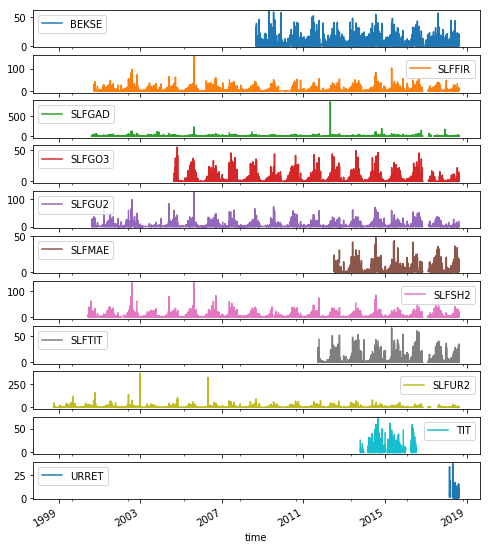

In [17]:
# view data
data.plot(figsize=[8,10], subplots=True);

### Get stations with at least 10 years of records
As seen prior, the stations *Eigergletscher* and *Kleine Scheidegg* are the only one with long enough records to be compared to the HistAlp data set (cp. `prepare_idaweb_precip_data.ipynb`). Hereafter we look at stations with over 10 years of precipitation records. This could give a better idea of the (monthly, yearly?!) precipitation sum and its variation in the region and/or with altitude...

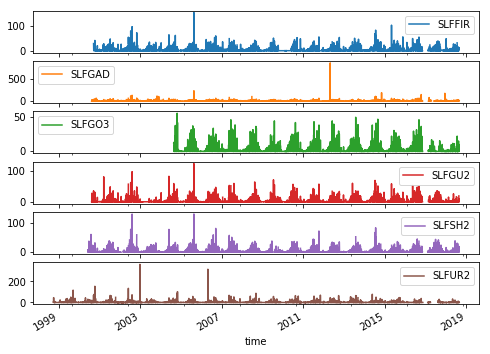

In [18]:
# count days with precip records per station
number_of_days = data.count()
# find stations with long enough records
stn = number_of_days[number_of_days > 3650].index
# subset for those stations
precip = data[stn]
precip.plot(subplots=True, figsize=[8,6]);

In [19]:
# get some basic statistics
precip.describe()

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
count,6104.000000,5903.000000,4927.000000,6053.000000,5801.000000,6808.000000
mean,3.367366,3.835846,2.167526,2.737039,3.203206,2.600808
std,7.731609,15.684698,5.219704,7.090604,7.360199,9.619388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,3.200000,1.600000,1.800000,3.000000,1.400000
max,153.000000,863.600000,55.000000,124.000000,131.600000,363.500000


Seems like there are some outliers, which we have to taken care of?!
Precipitation amounts of 863 mm in 24 hours can hardly be correct...

As long as I don't come up with any better idea I'll just chop everything above 120 mm...

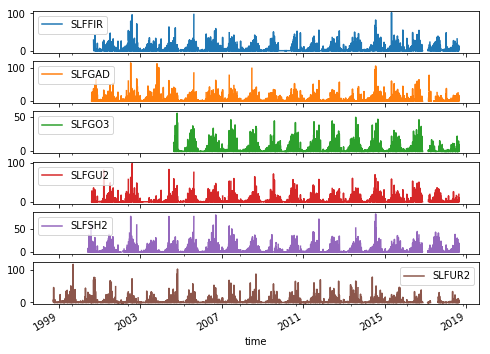

In [20]:
precip = precip[precip <= 120]
precip.plot(subplots=True, figsize=[8,6]);

In [21]:
# save this data to file
path = '../raw_data/station_data/daily_precip_slf.csv'
precip.to_csv(path)

In [22]:
# save station meta file
path = '../raw_data/station_data/slf_stations.csv'
stations.loc[precip.columns].to_csv(path)

### Monthly precipitation sum

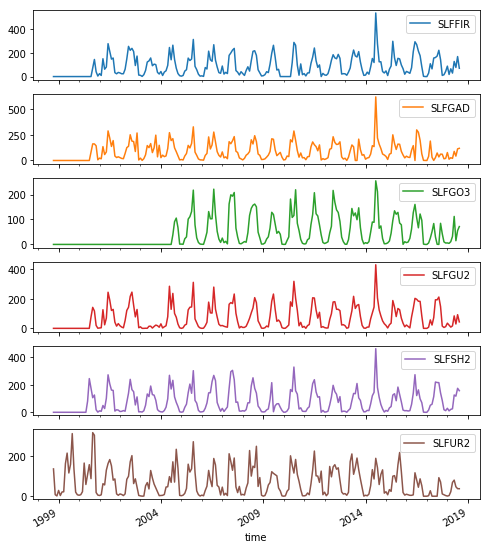

In [23]:
# compute monthly sums
precip_monthly = precip.resample('M').sum()
precip_monthly.plot(subplots=True, figsize=[8,10]);

In [24]:
# resample().sum() gives zero when summing NaNs,
# this skews the precipitation distribution.
# However, setting all month with no precipitation
# to NaN does not seem correct either...
precip_monthly[precip_monthly == 0].count()

SLFFIR    33
SLFGAD    25
SLFGO3    73
SLFGU2    29
SLFSH2    22
SLFUR2     7
dtype: int64

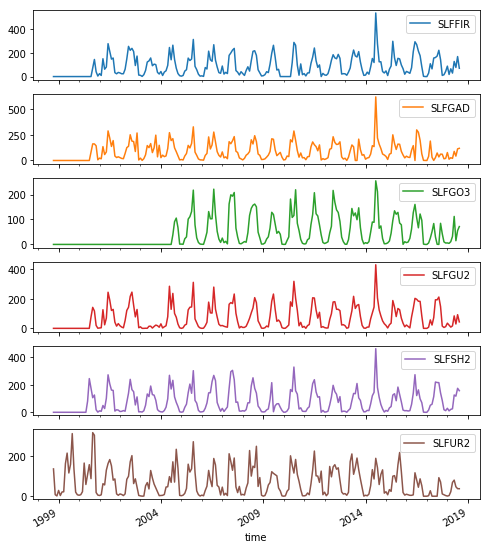

In [25]:
# compute monthly sums
precip_monthly = precip.resample('M').sum()
precip_monthly.plot(subplots=True, figsize=[8,10]);

**Well fuck it. I'm just gonny do it myself...!**
I want a function which sums precipitation over a month. So far, so easy and good. The problem arises from days without records, i.e. `NaN`. If its just a single day we assume it to be zero. Month with no records at all are treated as missing. But how to deal with month were multiple records are missing... We have to define a treshhold number of days, below which a monthly sum has no meaning...

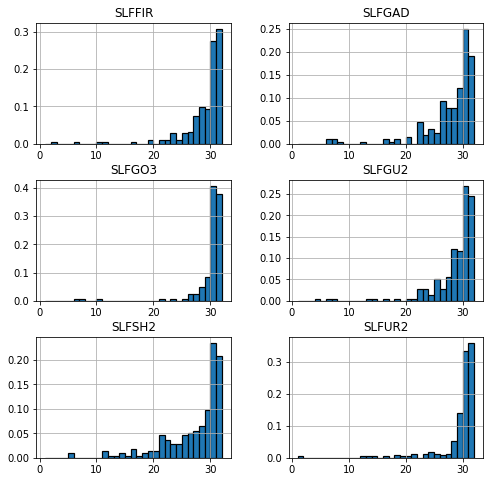

In [26]:
# let's see how many day per month are recorded
days_per_month = precip.resample('M').count()
# visualize findings using a histogramm
# with binsize of one day, excluding month
# without records (i.e. bin [0,1[)
bins = np.arange(1,33)
days_per_month.hist(bins=bins, figsize=[8,8], edgecolor='black', linewidth=1.2, density=True);

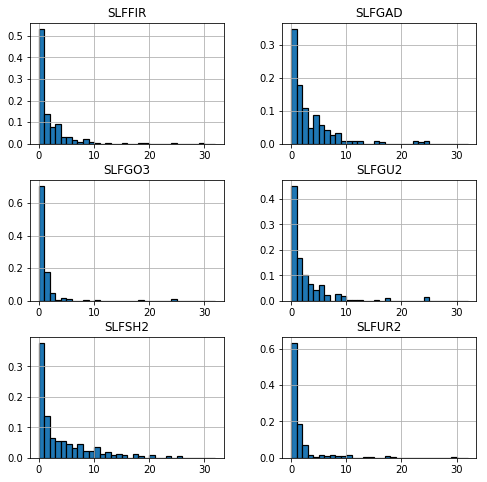

In [27]:
# count number of records per month
missing_days = precip.resample('M').count()
# all month without records (i.e. count == 0) are set to NaN
# since they are not of interest
missing_days[missing_days == 0] = np.nan
# compute number of missing records per month,
# by subtracting actual number of days per given month
missing_days = abs(missing_days.sub(missing_days.index.day.tolist(), axis=0))
# visualize findings using a histogramm
# with binsize of one day
bins = np.arange(0,33)
missing_days.hist(bins=bins, figsize=[8,8], edgecolor='black', linewidth=1.2, density=True);

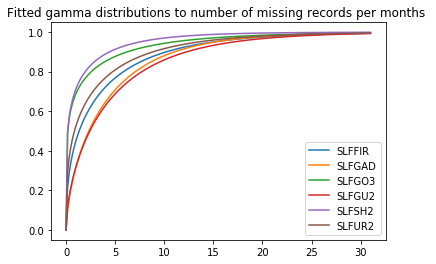

In [28]:
import matplotlib.pyplot as plt
from scipy import stats

# porepare data
data2fit = missing_days

# empty container to store distribution parametes
gamma = dict()

# TRY fitting a gamma distribution (yes, again...)
for i, d in data2fit.iteritems():
    # fit gamma distribution
    params = stats.gamma.fit(data=d.dropna())
    # add to container
    gamma[i] = params
    
# convert into DataFrame
gamma = pd.DataFrame(gamma).T
gamma.columns = ['shape', 'loc', 'scale']

# plot gamma cdf
x = np.linspace(0,31,200)
[plt.plot(x, stats.gamma.cdf(x, g['shape'], loc=g['loc'], scale=g['scale']), label=i) for i,g in gamma.iterrows()];
plt.title('Fitted gamma distributions to number of missing records per months ')
plt.legend()

In [29]:
# specify lower tail probability
ltp_list = [0.8, 0.85, 0.9, 0.95]
for ltp in ltp_list:
    # compute quantile for each distribution
    for i,g in gamma.iterrows():
        q = stats.gamma.ppf(ltp, g['shape'], loc=g['loc'], scale=g['scale'])
        print('{}: {:.0f}% quantile = {:0.1f} days'.format(i, ltp*1e2, q))
        
    print('-------------')

SLFFIR: 80% quantile = 5.8 days
SLFGAD: 80% quantile = 7.0 days
SLFGO3: 80% quantile = 2.6 days
SLFGU2: 80% quantile = 7.7 days
SLFSH2: 80% quantile = 1.9 days
SLFUR2: 80% quantile = 4.7 days
-------------
SLFFIR: 85% quantile = 7.6 days
SLFGAD: 85% quantile = 8.7 days
SLFGO3: 85% quantile = 3.9 days
SLFGU2: 85% quantile = 9.6 days
SLFSH2: 85% quantile = 2.9 days
SLFUR2: 85% quantile = 6.4 days
-------------
SLFFIR: 90% quantile = 10.2 days
SLFGAD: 90% quantile = 11.0 days
SLFGO3: 90% quantile = 6.2 days
SLFGU2: 90% quantile = 12.3 days
SLFSH2: 90% quantile = 4.4 days
SLFUR2: 90% quantile = 8.8 days
-------------
SLFFIR: 95% quantile = 15.0 days
SLFGAD: 95% quantile = 15.2 days
SLFGO3: 95% quantile = 10.9 days
SLFGU2: 95% quantile = 17.0 days
SLFSH2: 95% quantile = 7.5 days
SLFUR2: 95% quantile = 13.5 days
-------------


So... what was all of this for?! Well, actually I don't really know. But now I feel like making an educated guess: Based on the above findings, I'll skip month with more than 7 missing days. By doing so we will loose about 20% of all month for every station - this corresponds rougly to **4 YEARS!!**

In [32]:
stats.gamma.cdf(7, g['shape'], loc=g['loc'], scale=g['scale'])

0.8653459609914892

In [33]:
# specify threhold number of missing days
threshold = 7

# compute percentage of month with less missing days
for i,g in gamma.iterrows():
    p = stats.gamma.cdf(threshold, g['shape'], loc=g['loc'], scale=g['scale'])
    print('{}: {} days or less missing = {:.2f}% of months'.format(i, threshold, p*1e2))


SLFFIR: 7 days or less missing = 83.52% of months
SLFGAD: 7 days or less missing = 79.83% of months
SLFGO3: 7 days or less missing = 91.17% of months
SLFGU2: 7 days or less missing = 77.57% of months
SLFSH2: 7 days or less missing = 94.46% of months
SLFUR2: 7 days or less missing = 86.53% of months


### Concatenate precipitation data and number of missing records
In order to select meaningful data, information about monthly precipitation sum and number of missing records per month must be combined. First step is to add information about the parameter to the columns, by creating a MultiIndex with station name as first level. Both DataFrames are concatenated afterwards...

In [30]:
# get station name list
stn = precip_monthly.columns
# create MultiIndex adding information about the parameter
columns = pd.MultiIndex.from_product([stn, ['precip']])
# set new MultiIndex
monthly_data = precip_monthly.copy()
monthly_data.columns = columns
monthly_data.head()

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
,precip,precip,precip,precip,precip,precip
time,,,,,,
1998-10-31,0.0,0.0,0.0,0.0,0.0,136.0
1998-11-30,0.0,0.0,0.0,0.0,0.0,7.6
1998-12-31,0.0,0.0,0.0,0.0,0.0,1.4
1999-01-31,0.0,0.0,0.0,0.0,0.0,28.8
1999-02-28,0.0,0.0,0.0,0.0,0.0,3.4


In [31]:
# get station name list
stn = missing_days.columns
# create MultiIndex adding information about the parameter
columns = pd.MultiIndex.from_product([stn, ['n_missing']])
# set new MultiIndex
missing_days.columns = columns
missing_days.head()

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
,n_missing,n_missing,n_missing,n_missing,n_missing,n_missing
time,,,,,,
1998-10-31,NaN,NaN,NaN,NaN,NaN,0.0
1998-11-30,NaN,NaN,NaN,NaN,NaN,0.0
1998-12-31,NaN,NaN,NaN,NaN,NaN,0.0
1999-01-31,NaN,NaN,NaN,NaN,NaN,0.0
1999-02-28,NaN,NaN,NaN,NaN,NaN,0.0


In [32]:
# combine precipitation data with 'number of days'
final_data = pd.concat([monthly_data, missing_days], axis=1)
# sort columns by station name
final_data.sort_index(axis='columns', level=0, inplace=True)
final_data.head()

SLFFIR           SLFGAD           SLFGO3           SLFGU2  \
           n_missing precip n_missing precip n_missing precip n_missing   
time                                                                      
1998-10-31       NaN    0.0       NaN    0.0       NaN    0.0       NaN   
1998-11-30       NaN    0.0       NaN    0.0       NaN    0.0       NaN   
1998-12-31       NaN    0.0       NaN    0.0       NaN    0.0       NaN   
1999-01-31       NaN    0.0       NaN    0.0       NaN    0.0       NaN   
1999-02-28       NaN    0.0       NaN    0.0       NaN    0.0       NaN   

                     SLFSH2           SLFUR2         
           precip n_missing precip n_missing precip  
time                                                 
1998-10-31    0.0       NaN    0.0       0.0  136.0  
1998-11-30    0.0       NaN    0.0       0.0    7.6  
1998-12-31    0.0       NaN    0.0       0.0    1.4  
1999-01-31    0.0       NaN    0.0       0.0   28.8  
1999-02-28    0.0       NaN    0.0       0.0    3.4

Turns out, it's more usefull to keep both data frames apart from each other... well, FORK!

### Get usefull data
First all `NaN` counts will be set to 99 (arbitrary high number). The second step is to set all monthly sums with more than 7 missing days to `NaN`.

In [33]:
# get rid of MultiIndex again...
monthly_data.columns = monthly_data.columns.droplevel(1)
missing_days.columns = missing_days.columns.droplevel(1)

In [34]:
# set number of missing records of month without any data records
# to an arbitrary high number (> 31)
missing_days[pd.isna(missing_days)] = 99
missing_days.head()

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
time,,,,,,
1998-10-31,99.0,99.0,99.0,99.0,99.0,0.0
1998-11-30,99.0,99.0,99.0,99.0,99.0,0.0
1998-12-31,99.0,99.0,99.0,99.0,99.0,0.0
1999-01-31,99.0,99.0,99.0,99.0,99.0,0.0
1999-02-28,99.0,99.0,99.0,99.0,99.0,0.0


In [35]:
# define threshhold of max number of days with missing records
threshhold = 7
# set precip sum of month with too much missing records to NaN
monthly_data[missing_days > threshhold] = np.nan

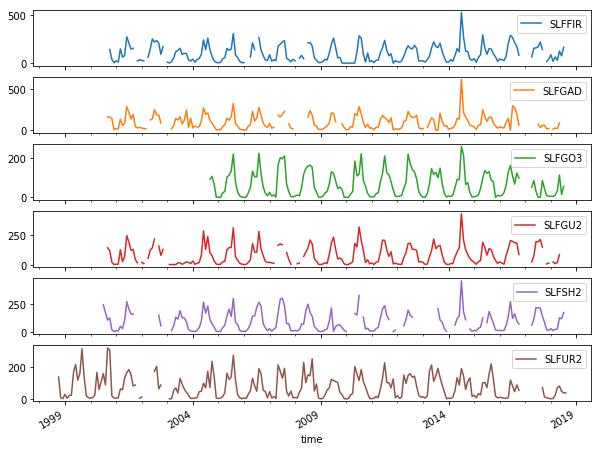

In [36]:
monthly_data.plot(subplots=True, figsize=[10,8]);

In [37]:
# compute correlation between individual stations
monthly_data.corr().loc[:, ['SLFUR2']]

,SLFUR2
SLFFIR,0.682355
SLFGAD,0.627116
SLFGO3,0.842222
SLFGU2,0.714642
SLFSH2,0.677416
SLFUR2,1.000000


In [38]:
# last step is to change the index
# from last days of the month to the first
# this is necessary to be compatible 
# with the HistAlp format
monthly_data.index = monthly_data.index.strftime('%Y-%m')

In [40]:
# save data to file
path = '../raw_data/station_data/monthly_precip_slf.csv'
monthly_data.to_csv(path)

Does all of that make any sense?! I don't know and frankly I don't really care... It's time to go home now!

### Get yearly sums

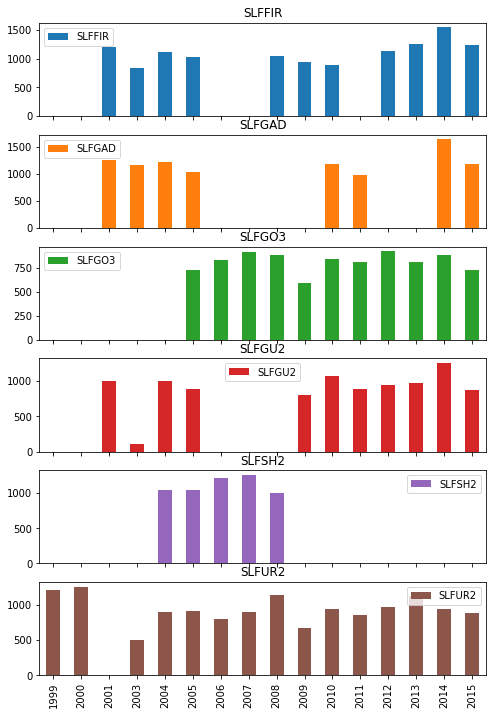

In [41]:
# compute yearly sum for years with over 340 days with records
precip_yearly = precip.resample('Y').sum(min_count=340)
# reformat index
precip_yearly.index = [i.strftime('%Y') for i in precip_yearly.index]
# drop years without records
precip_yearly.dropna(how='all', inplace=True)
# visualize
precip_yearly.plot(subplots=True, figsize=[8,12], kind='bar');

In [42]:
# save data to file
path = '../raw_data/station_data/yearly_precip_slf.csv'
precip_yearly.to_csv(path)

### Get average yearly precipitation sum

In [68]:
# average over yearly sums
yearly_avg_0 = precip_yearly.mean()
# compute daily mean and calculate yearly mean
yearly_avg_1 = (precip.mean()*365)

# concat into one DataFrame
yearly_avg = pd.concat([yearly_avg_0, yearly_avg_1], axis=1)
yearly_avg.columns = ['from_years', 'from_days']
yearly_avg

,from_years,from_days
SLFFIR,1112.127273,1220.139440
SLFGAD,1215.100000,1269.105495
SLFGO3,812.945455,791.146945
SLFGU2,890.418182,991.705965
SLFSH2,1118.520000,1153.032419
SLFUR2,929.146667,897.854938


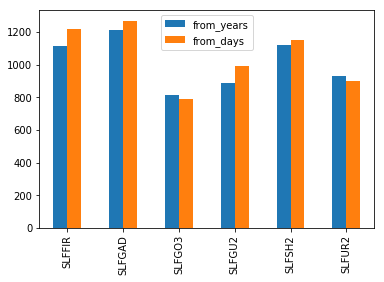

In [69]:
# visualize
yearly_avg.plot(kind='bar')

Both above used methods are far from flawless, but at least they yield comparable results. Since we are more interested in a generall estimation than an exact value (which is not obtainable with the availible data), I suggest to average again over the result of both methods.

**WARNING:** the period with records is different for all stations...

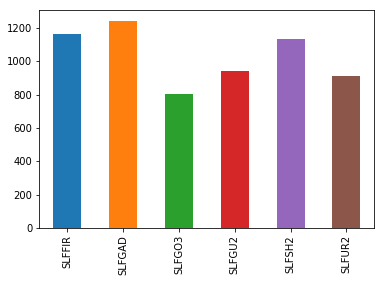

In [70]:
yearly_avg = yearly_avg.mean(axis=1)
yearly_avg.plot(kind='bar')

In [71]:
# save to file
path = '../raw_data/station_data/yearly_precip_avg_slf.csv'
yearly_avg.to_csv(path)

## IDAWEB selection: temperature
The only station in the above define geographical region with sensible data for a long enough period is the *Jungfraujoch* (JUN). It has records of daily and monthly temperature mean...

In [72]:
# specfify path to order directory
order_path = '../raw_data/idaweb_data/order61939/'
index_file, legend_files, data_files = idaweb.list_files(order_path)
# read index file
index_data = idaweb.read_index_file(os.path.join(order_path, index_file), file_type='Data')
index_meta = idaweb.read_index_file(os.path.join(order_path, index_file), file_type='Legend')
# get index file column names
index_columns = idaweb.index_columns['en']
print(index_columns)

{'name': 'Filename', 'type': 'Filetype', 'station': 'Station', 'param': 'Parameter', 'period': 'Period'}


In [73]:
index_data

,Filename,Filetype,Station,Parameter,Period
0,order_61939_JUN_tre200m0_1_data.txt,Data,Jungfraujoch,Air temperature 2 m above ground; monthly mean,193212-201808
2,order_61939_JUN_tre200d0_1_data.txt,Data,Jungfraujoch,Air temperature 2 m above ground; daily mean,19321231-20180909


In [74]:
index_meta

,Filename,Filetype,Station,Parameter,Period
1,order_61939_JUN_tre200m0_1_legend.txt,Legend,Jungfraujoch,Air temperature 2 m above ground; monthly mean,193212-201808
3,order_61939_JUN_tre200d0_1_legend.txt,Legend,Jungfraujoch,Air temperature 2 m above ground; daily mean,19321231-20180909


#### View meta files
The *Legend* file list meta *Data* for the corresponding data file. This includes the used stations, there properties (coordinates, altitude, ...) and parameters.

In [75]:
# create empty containers for stations and parameters
stations = list()
parameters = list()
# read all legend files
for meta in index_meta[index_columns['name']]:
    meta = os.path.join(order_path, meta)
    # legend file contains station and parameter list
    stn, param = idaweb.read_legend_file(meta)
    # add to corresponding container
    stations.append(stn)
    parameters.append(param)
    
# convert into DataFrames
stations = pd.concat(stations, axis=0).drop_duplicates()
parameters = pd.concat(parameters, axis=0).drop_duplicates()

In [76]:
stations

,Name,Parameter,Data source,Longitude/Latitude,Coordinates [km],Elevation [m]
stn,,,,,,
JUN,Jungfraujoch,tre200m0,MeteoSchweiz,7°59'/46°33',641930/155275,3580
JUN,Jungfraujoch,tre200d0,MeteoSchweiz,7°59'/46°33',641930/155275,3580


In [78]:
stations.iloc[[0]].to_csv('../raw_data/station_data/monthly_temp_stations.csv')

In [79]:
parameters

,Unit,Description
tre200m0,°C,Air temperature 2 m above ground; monthly mean
tre200d0,°C,Air temperature 2 m above ground; daily mean


### Read monthly mean air temperature
In the following I read the termperature data from files, using the reading function of my IDAWEB module. Some manipulations (like date parsing) are performed on the DataFrame, before the data is stored to file in order to allow further usage... 

In [80]:
# define data parser for year month date format
montly_parser = lambda x: pd.datetime.strptime(x, '%Y%m')

In [81]:
# get the filename of the monthly precip recors
data_file = index_data.loc[index_data[index_columns['param']].str.contains('month'), index_columns['name']].values[-1]
data_file = os.path.join(order_path, data_file)
# read data file with monthly data records
data = idaweb.read_data_file(data_file, date_parser=montly_parser)

In [82]:
# remove rows (days) without data
data.dropna(how='all', inplace=True)

In [83]:
# get rid of the parameter label in column name
param_label = 'tre200m0_'
# get current column labels
columns = data.columns

# remove parameter label
new_columns = [c.replace(param_label, '') for c in columns]
# set new columns to DataFrame
data.columns = new_columns

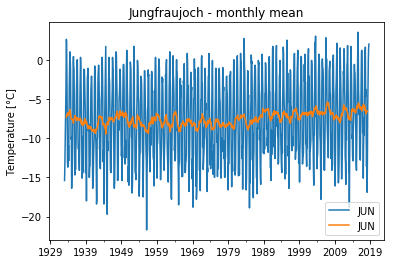

In [84]:
# view data
data.plot()
ax = plt.gca()
data.rolling(12, center=True).mean().plot(ax=ax, title='Jungfraujoch - monthly mean')
ax.set_xlabel('')
ax.set_ylabel('Temperature [°C]');

In [86]:
# copy DataFrame
temp_monthly = data.copy()

### Read daily mean temperature
Read the daily mean temperature of the same station. Compare to monthly data...

In [87]:
# define data parser for year month date format
daily_parser = lambda x: pd.datetime.strptime(x, '%Y%m%d')

In [88]:
# get the filename of the monthly precip recors
data_file = index_data.loc[index_data[index_columns['param']].str.contains('daily'), index_columns['name']].values[-1]
data_file = os.path.join(order_path, data_file)
# read data file with monthly data records
data = idaweb.read_data_file(data_file, date_parser=daily_parser)

In [89]:
# remove rows (days) without data
data.dropna(how='all', inplace=True)

In [90]:
# get rid of the parameter label in column name
param_label = 'tre200d0_'
# get current column labels
columns = data.columns

# remove parameter label
new_columns = [c.replace(param_label, '') for c in columns]
# set new columns to DataFrame
data.columns = new_columns

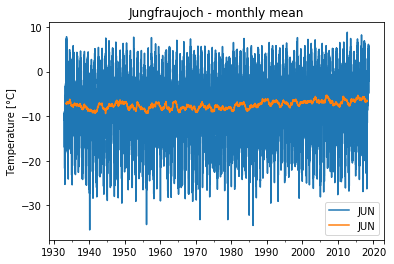

In [91]:
# view data
data.plot()
ax = plt.gca()
data.rolling(360, center=True).mean().plot(ax=ax, title='Jungfraujoch - monthly mean')
ax.set_xlabel('')
ax.set_ylabel('Temperature [°C]');

In [92]:
# resample daily to monthly data
temp_monthly_resample = data.resample('M',).mean()
# round to single decimal digit
temp_monthly_resample = temp_monthly_resample.round(decimals=1)
# set timestamp index to first day of month
temp_monthly_resample.index = [pd.datetime.strptime(i, '%Y-%m') for i in temp_monthly_resample.index.strftime('%Y-%m').values]

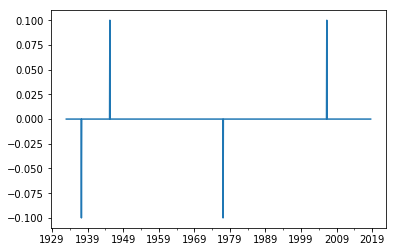

In [93]:
# concat both DataFrames
tmp = pd.concat([temp_monthly,temp_monthly_resample], axis=1)
# adjust column names
tmp.columns = ['monthly', 'from_daily']
# compute difference
tmp['difference'] = tmp.monthly - tmp.from_daily
tmp.difference.plot()

**Observation:** the daily records don't carry any additional (or different) information, regarding the monthly mean.

In [94]:
# save this data to file
path = '../raw_data/station_data/monthly_temp_jungfrau.csv'
temp_monthly.to_csv(path)

### Some other stuff that didn't really work...

#### Fitting a Gamma distribution to the precipitaion data

In [ ]:
# import the statistics module from the scipy package
from scipy import stats
# plotting libs
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# dump all precipitation records into one list
data2fit = precip.values.flatten()
# remove non numeric values
data2fit = data2fit[np.isfinite(data2fit)]
# dont account for days without precipitation
data2fit = data2fit[data2fit > 0]

# fit gamma distribution
alpha, loc, beta = stats.gamma.fit(data2fit)

In [ ]:
# compute pdf
x = np.linspace(1,200,100)
gamma = stats.gamma.pdf(x, a=alpha, loc=loc, scale=beta)
plt.plot(x, gamma)

In [ ]:
bins = [0.5,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,800] 

In [ ]:
plt.hist(data2fit, density=True, bins=bins);

In [ ]:
# plot
plt.hist(data2fit, density=True, bins=bins)
plt.gca().twinx()
plt.plot(x, gamma, c='r')
plt.gca().set_ylim([0,max(gamma)*1.05])

**Pandas sum over all NaNs returns 0?!**

In [ ]:
df1 = pd.DataFrame()
df1['a'] = [1,2,np.nan,3]
df1['b'] = [np.nan,2,np.nan,3]

In [ ]:
df1

In [ ]:
df1.sum(axis=1, skipna=False)